### Doodle Classifier Project

### Dependencies

In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [39]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
	tf.config.experimental.set_memory_growth(gpu,True)

for gpu in gpus:
	print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Loading the data

In [40]:
train_df = tf.keras.preprocessing.image_dataset_from_directory("Data/train",color_mode="grayscale",image_size=(256,256))

class_names = train_df.class_names
print(class_names)

Found 32640 files belonging to 51 classes.
['airplane', 'anvil', 'apple', 'axe', 'banana', 'bandage', 'baseball', 'basketball', 'bed', 'bee', 'bicycle', 'blackberry', 'book', 'bowtie', 'bus', 'butterfly', 'cake', 'calculator', 'calendar', 'campfire', 'car', 'carrot', 'cat', 'cell phone', 'circle', 'cloud', 'coffee cup', 'computer', 'cookie', 'diamond', 'dog', 'donut', 'envelope', 'eye', 'face', 'fish', 'flower', 'guitar', 'hammer', 'hat', 'headphones', 'house', 'ice cream', 'lollipop', 'pants', 'pizza', 'skull', 'smiley face', 't-shirt', 'underwear', 'wristwatch']


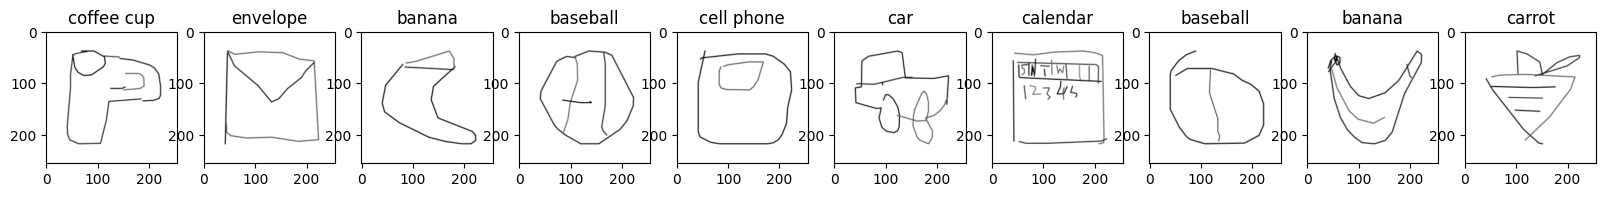

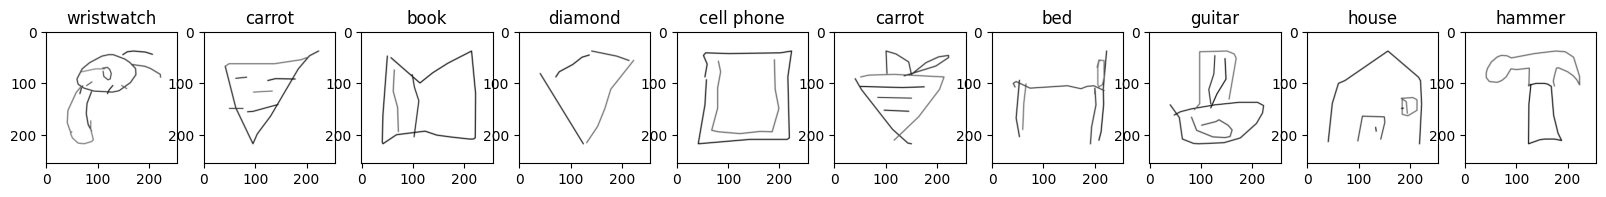

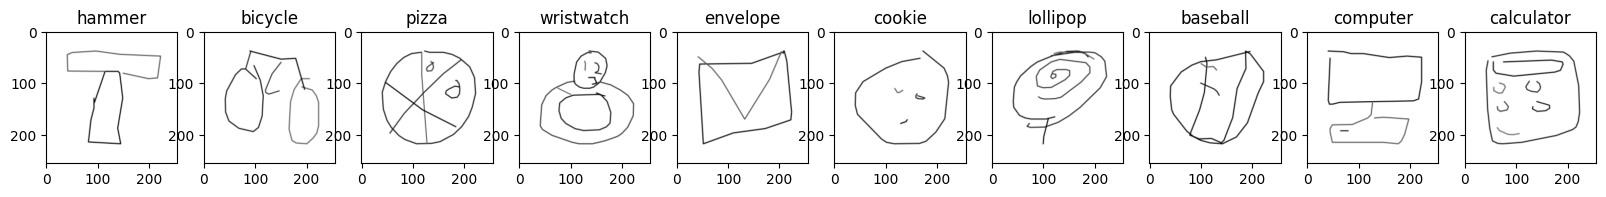

In [41]:
for x in range(3):
    batch = train_df.as_numpy_iterator().next()
    fig,ax = plt.subplots(ncols = 10,figsize = (20,20))
    for idx,img in enumerate(batch[0][:10]):
    	ax[idx].imshow(img.astype(int),cmap = "gray")
    	ax[idx].title.set_text(class_names[batch[1][idx]])

### Preprocessing the Data

In [48]:
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    fill_mode="nearest",
validation_split=0.2)

preprocessed_train = data_aug.flow_from_directory("Data/train",color_mode="rgb",target_size=(256,256),subset="training",class_mode="categorical")
val_df = data_aug.flow_from_directory("Data/train",color_mode="rgb",target_size=(256,256),subset="validation",class_mode="categorical")

Found 26112 images belonging to 51 classes.
Found 6528 images belonging to 51 classes.


### Building the Neural Network

In [49]:
vgg = tf.keras.applications.VGG16(include_top = False,input_shape=(256,256,3))

for layers in vgg.layers:
    layers.trainable = False

In [50]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(256,256,1)))
model.add(tf.keras.layers.Conv2D(64,kernel_size=3))
model.add(tf.keras.layers.LeakyReLU(0.2))
model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

model.add(tf.keras.layers.Conv2D(128,kernel_size=3))
model.add(tf.keras.layers.LeakyReLU(0.2))
model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

model.add(tf.keras.layers.Conv2D(256,kernel_size=3))
model.add(tf.keras.layers.LeakyReLU(0.2))
model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64,activation = "relu"))
model.add(tf.keras.layers.Dense(51,activation = "softmax"))



model = tf.keras.models.Sequential()

model.add(vgg)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64,activation = "relu"))
model.add(tf.keras.layers.Dense(51,activation = "softmax"))

In [51]:
LOSS = "mse"
METRICS = ["accuracy"]
OPTIMIZERS = "adam"

model.compile(loss = LOSS,optimizer = OPTIMIZERS,metrics = METRICS)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 64)                32832     
                                                                 
 dense_19 (Dense)            (None, 51)                3315      
                                                                 
Total params: 14,750,835
Trainable params: 36,147
Non-trainable params: 14,714,688
_________________________________________________________________


In [52]:
callbacks = tf.keras.callbacks.EarlyStopping(restore_best_weights=True,verbose = 1,patience=5,monitor="val_loss")
hist = model.fit(preprocessed_train,epochs = 30,batch_size = 32,callbacks=callbacks,validation_data=val_df)

Epoch 1/30
277/816 [=========>....................] - ETA: 1:27 - loss: 0.0190 - accuracy: 0.0935

KeyboardInterrupt: 